In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
duration = 10 # sec
N = 10
num_samples = 1000
time_index = np.linspace(0, duration, num_samples)

TSDS = {"1": [], "2": []}


# Группа косинусов
for i in range(N):
    TSDS["1"].append(
        8*np.cos(0.6*np.pi*time_index + np.random.uniform(50, 100)) + (np.random.normal(0, 1, num_samples)*np.random.normal(1, 4, num_samples)*np.sin(np.pi*time_index))
    )

# Группа модифицированных синусов
for i in range(N):
    TSDS["2"].append(
        15*np.sin(6*np.pi*np.sin(np.pi + time_index) + 2*np.random.uniform(1, 3)) + \
                              5*np.sin(2*np.pi*time_index + 3*np.random.uniform(2, 10)) + 10*(np.random.random() + 0.65) + \
                              + np.random.normal(1, 4, num_samples)*pow(2*np.cos(2*np.pi*time_index), 2)
    )
                              

Графики

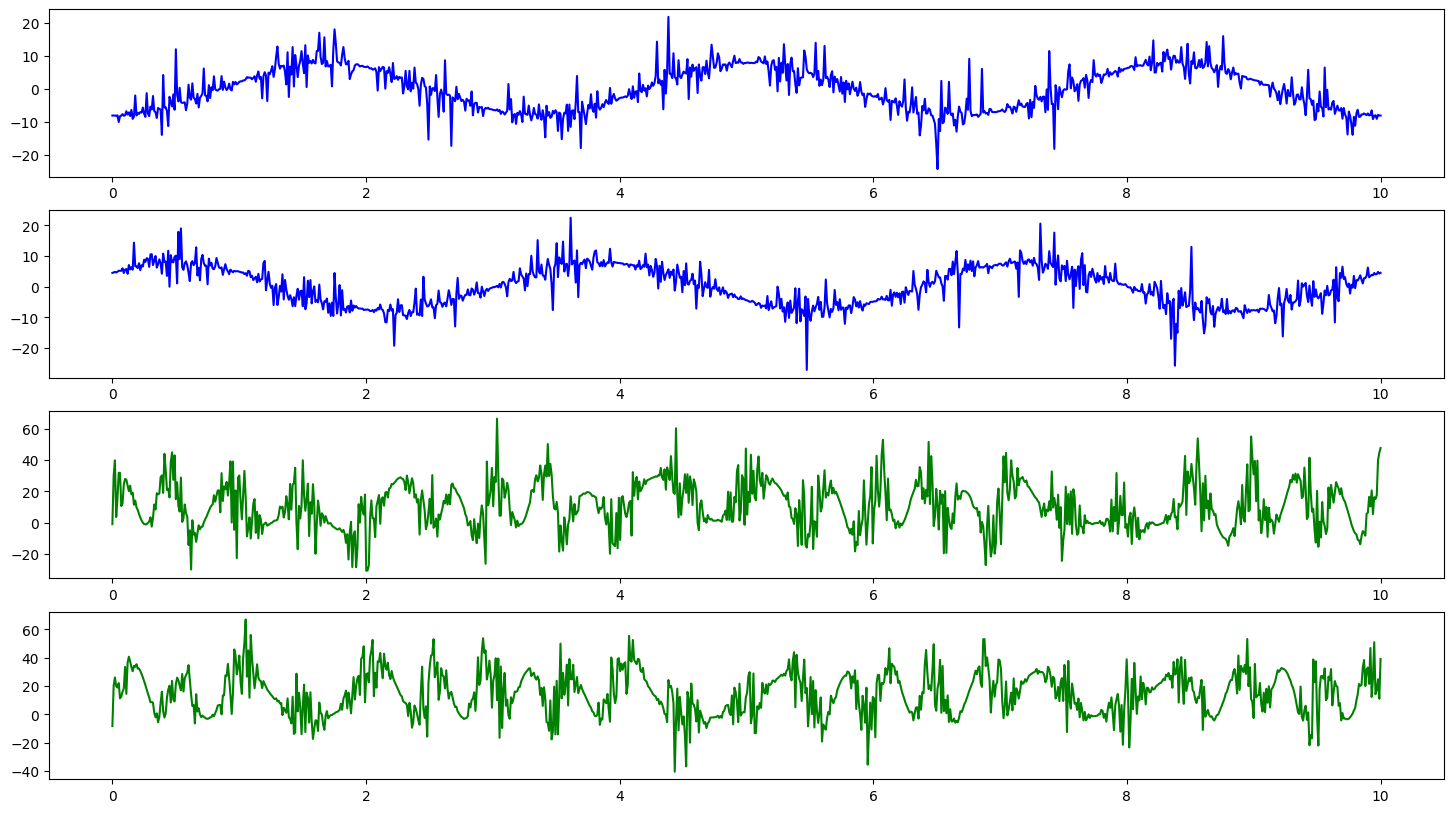

In [3]:

fig, axs = plt.subplots(4, 1,figsize=(18, 10))

axs[0].plot(time_index, TSDS["1"][1], '-b')
axs[1].plot(time_index, TSDS["1"][3], '-b')

axs[2].plot(time_index, TSDS["2"][1], '-g')
axs[3].plot(time_index, TSDS["2"][3], '-g')

Магия C++

In [4]:
import ctypes, ctypes.util

# Import dll
lib = ctypes.CDLL("./src/help_lib.dll")

# Wrappers
lib.compute_distances.restype = None
lib.compute_distances.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int32), ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.double), ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.int32), np.ctypeslib.ndpointer(dtype=np.double)]

def compute_distances(Wl: list, subseq_idx: int, shapelet_idx: int):
    wl_classes = np.array([int(c[0]) for c in Wl], dtype=np.int32)
    wl_shapelets = np.array([np.array(subseq[1], dtype=np.double).flatten() for subseq in Wl], dtype=np.double).flatten()

    out_classes = np.zeros(len(wl_classes), dtype=np.int32)
    out_dists = np.zeros(len(wl_classes), dtype=np.double)

    lib.compute_distances(wl_classes, len(wl_classes),
                          wl_shapelets, len(Wl[0][1]), len(Wl[0][1][0]),
                          subseq_idx, shapelet_idx,
                          out_classes, out_dists
                          )
    return [(c, dist) for c, dist in zip(out_classes, out_dists)]
    
compute_distances([("1", np.array([[1, 2, 3], [2, 3, 4], [3, 4, 5]], dtype=np.double)),
                  ("2", np.array([[33, 63, -2], [85,-8, 4], [-43, 55, 9]], dtype=np.double)),
                  ("3", np.array([[0, 1, -2], [2, 1, 4], [-4, 5, 9]], dtype=np.double))], 2, 0)

[(1, 27.0), (2, 4886.0), (3, 0.0)]

In [1]:
import ctypes
from ctypes import *
import numpy as np

lib = ctypes.CDLL("./src/help_lib.dll")

class TS_Array:
    class __API_TS_Array(Structure):
        _fields_ = [("classIdx", c_uint32), ("length", c_uint32), ("values", POINTER(c_double))]

    def __init__(self, class_id, values):
        self.__length = len(values)
        self.__values_pointer = c_double * self.__length
        self.__cpp_struct = TS_Array.__API_TS_Array(class_id, self.__length, self.__values_pointer(*values))
    
    def get_values(self):
        return self.__cpp_struct.values[:self.__length]
    
    def set_values(self, values):
        self.__length = len(values)
        self.__values_pointer = c_double * self.__length
        self.__cpp_struct.values = self.__values_pointer(*values)

    def get_class(self):
        return int(self.__cpp_struct.classLabel)
    
    def set_class(self, class_id):
        self.__cpp_struct.classLabel = class_id

    values = property(
        fget=get_values,
        fset=set_values
    )

    class_idx = property(
        fget=get_class,
        fset=set_class
    )

In [4]:
a = TS_Array(1, np.array([1, 2, 3, 456456]))
a.values

[1.0, 2.0, 3.0, 456456.0]

Алгоритм

In [23]:
def generate_candidates(TSDS: dict, l) -> dict:
    candidates = []

    for class_label, ts_list in TSDS.items():
        for ts in ts_list:
            ts_len = len(ts)
            candidates.append((class_label, [ts[i:i+l] for i in range(ts_len - l + 1)]))

    return candidates

generate_candidates({"1231": [[1, 2, 3, 4, 5, 6], [1, 2, 9]]}, 3)

[('1231', [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6]]), ('1231', [[1, 2, 9]])]

In [29]:
Wl = generate_candidates(TSDS, 10)

In [39]:
%%time
compute_distances_old(Wl, 0, 0)

CPU times: total: 31.2 ms
Wall time: 66.9 ms


[('1', 0.0),
 ('1', 1.1237491370469859),
 ('1', 0.6773841982787973),
 ('1', 0.6310177802141345),
 ('1', 1.5345429733093705),
 ('1', 1.2650352094295951),
 ('1', 1.9263755057086756),
 ('1', 0.8825965282846938),
 ('1', 1.4913500633173553),
 ('1', 0.39608323621566544),
 ('2', 142.86297318679178),
 ('2', 8.956962374789446),
 ('2', 20.841741020160832),
 ('2', 5.839054054935721),
 ('2', 64.90677913748877),
 ('2', 122.07651116095944),
 ('2', 85.79328806005262),
 ('2', 160.83993520870487),
 ('2', 17.49309035648302),
 ('2', 108.67565670166438)]

In [49]:
%%time
for subseq_idx in range(len(Wl)):
    c = Wl[subseq_idx][0]
    ts = Wl[subseq_idx][1]
    for shapelet_idx in range(len(ts)):
        compute_distances(Wl, subseq_idx, shapelet_idx)
    print(c)

1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
CPU times: total: 3min 18s
Wall time: 3min 30s


In [33]:
def dist_old(s, r) -> float:
    sum = 0
    for si, ri in zip(s, r, strict=False):
        sum += (si - ri)**2
    return sum

def compute_distances_old(Wl: list, subseq_idx, shapelet_idx) -> float:
    dists = [None]*len(Wl)

    s = Wl[subseq_idx][1][shapelet_idx]
    for i in range(len(Wl)):
        c = Wl[i][0]
        ts = Wl[i][1]
        if (i == subseq_idx):
            dists[i] = (c, 0.0)
            continue
        
        min_dist = dist_old(s, ts[0])
        for r in ts[1:]:
            d = dist_old(s, r)
            if d < min_dist:
                min_dist = d

        dists[i] = (c, min_dist)

    return dists

compute_distances_old([("1", [[1, 2, 3], [2, 3, 4], [3, 4, 5]]),
                  ("2", [[33, 63, -2], [85,-8, 4], [-43, 55, 9]]),
                  ("3", [[0, 1, -2], [2, 1, 4], [-4, 5, 9]])], 2, 0)

[('1', 27), ('2', 4886), ('3', 0.0)]

In [41]:
def entropy(n, l):
    return 0.0 if (n == 0) else -(n / l)*np.log(n / l)

In [43]:
def gain(classes, delim, class_names):
    l = len(classes)
    left = classes[:delim]
    left_l = len(left)
    right = classes[delim:]
    right_l = len(right)
    return sum([entropy(classes.count(cls), l) for cls in class_names]) - (
        (left_l / l) * sum([entropy(left.count(cls), left_l) for cls in class_names]) +
        (right_l / l) * sum([entropy(right.count(cls), right_l)  for cls in class_names])
    )

def evaluate_condidates(dists: list, class_names):
    dists.sort(key=lambda x: x[1])
    classes = [d[0] for d in dists]

    max_gain = 0
    l = len(classes)
    for i in range(1, l):
        IG = gain(classes, i, class_names)
        if IG > max_gain:
            max_gain = IG
    return max_gain
    
evaluate_condidates([("1", 2), ("2", 1)], ["1", "2"])

0.6931471805599453

In [44]:
def remove_dublicates(shapelets: list, shapelets_temp: list, limit) -> list:
    q_set = set()
    # print(len(shapelets_temp), len(set([s[1] for s in shapelets_temp])))

    shapelets_temp.sort(key=lambda x: x[1], reverse=True)
    cnt = 0
    for s, q in shapelets_temp:
        if q not in q_set:
            shapelets.append(s)
            q_set.add(q)
            cnt += 1
        if cnt == limit:
            break


In [45]:
def get_shapelets(TSDS: dict, min_len, max_len, limit, q=0.05):
    class_names = set(TSDS.keys())
    shapelets = []

    for l in range(min_len, max_len+1):
        Wl = generate_candidates(TSDS, l)
        shapelets_temp = []
        for subseq_idx in range(len(Wl)):
            c = Wl[subseq_idx][0]
            ts = Wl[subseq_idx][1]
            for shapelet_idx in range(len(ts)):
                Ds = compute_distances(Wl, subseq_idx, shapelet_idx)
                quality = evaluate_condidates(Ds, class_names)
                if quality > q:
                    shapelets_temp.append((ts[shapelet_idx], quality))
        print(c)
        remove_dublicates(shapelets, shapelets_temp, limit)
    return shapelets

            
shapelets = get_shapelets(TSDS, 20, 20, 10)


KeyboardInterrupt: 

In [100]:
shapelets[0]

array([-7.99990005, -9.45775007, -3.87997103, -6.94255151, -6.45994583,
       -4.47565799, -1.59707374, -3.18731611,  1.52035679,  1.01693503,
        2.68898228,  1.03558993,  5.1375035 ,  5.58278443, -1.83798756,
        5.94886078,  9.94306984,  6.67264707,  8.01141729,  6.27966257])

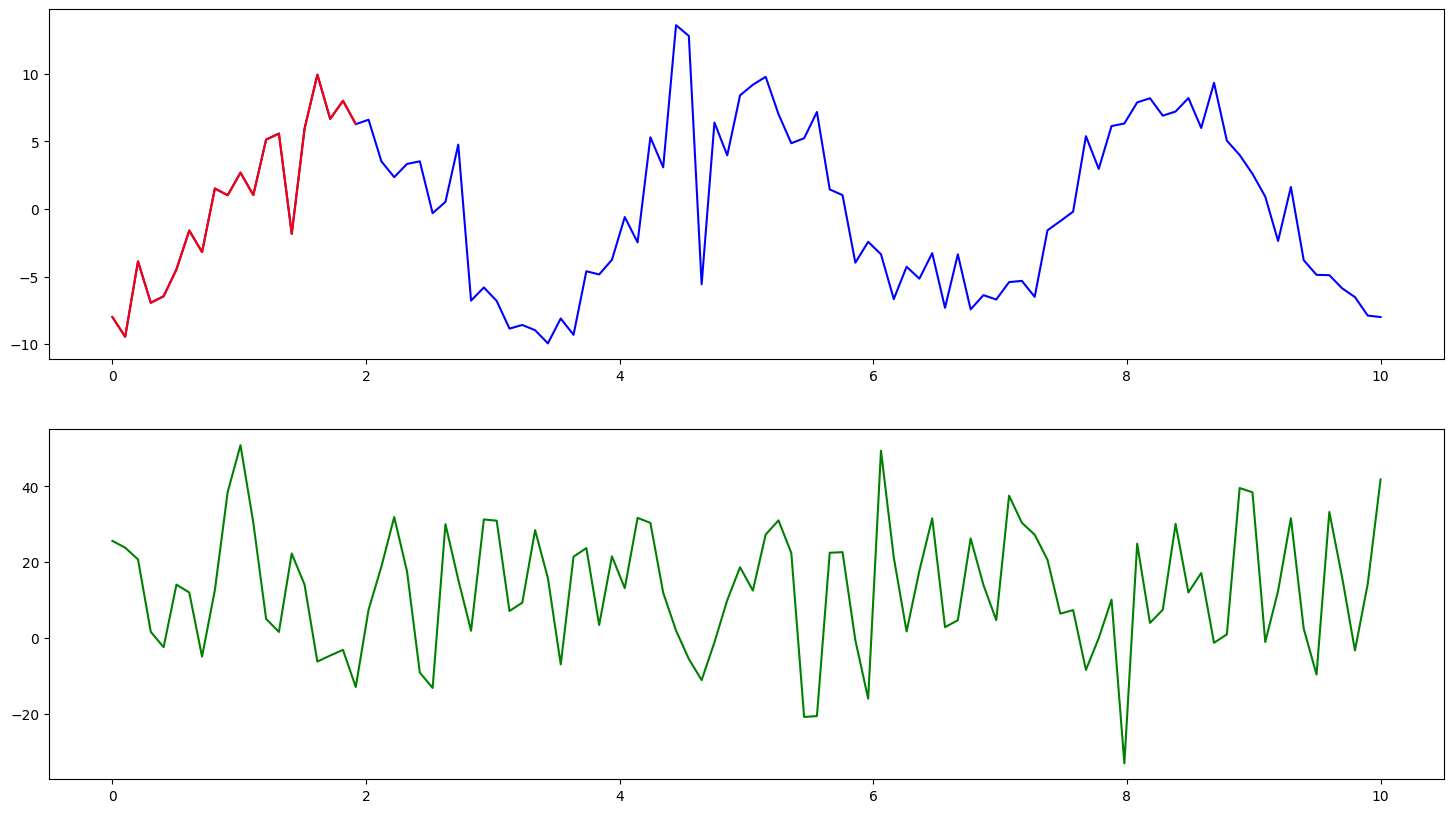

In [113]:
fig, axs = plt.subplots(2, 1,figsize=(18, 10))

axs[0].plot(time_index, TSDS["class_1"][0], '-b')
axs[1].plot(time_index, TSDS["class_2"][1], '-g')

axs[0].plot(np.linspace(0, 1.92, 20), shapelets[0], '-r')